In [1]:
from functools import reduce
import struct
import numpy as np
import cv2
import datetime
#import helpers # helper functions
import os
import glob # library for loading images from a directory  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sample_types import CommandCode
from sample_types import ResponseCode
from sample_types import Color
from SerialInterface import SerialInterface

VIDEO_STREAM_MODE = False
# 座標IDとピクセル座標の連想リスト(ピクセル座標はカメラ位置に応じて調整して下さい)
#dots = {   1 : (750, 267),  2 : (875, 267),  3 : (1000, 267),  4 : (1125, 267),   5 : (753, 367),  6 : (885, 367),  7 : (1015, 367),  8 : (1150, 367),   9 : (755, 481), 10 : (897, 481), 11 : (1037, 481), 12 : (1174, 481),  13 : (761, 604), 14 : (908, 604), 15 : (1055, 604), 16 : (1200, 604) }
dots = {   1 : (600, 100),  2 : (800, 100),  3 : (1000, 100),  4 : (1200, 100),   5 : (600, 300),  6 : (800, 300),  7 : (1000, 300),  8 : (1200, 300),   9 : (600, 500), 10 : (800, 500), 11 : (1000, 500), 12 : (1200, 500),  13 : (600, 700), 14 : (800, 700), 15 : (1000, 700), 16 : (1200, 700) }
points = dots.values() # 全サークル分の座標リストを作る

In [2]:
if VIDEO_STREAM_MODE:
    print("capture image from video stream")
else:
    print("read image from file")

read image from file


In [3]:
def load_image_set(image_dir):

    # Populate this empty image list                                                                    
    im_list = []
    # Iterate through each image file in each image_type folder                                         
    # glob reads in any image with the extension "image_dir/im_type/*"                                  
    for file in glob.glob(os.path.join(image_dir,"*")):

        # Read in the image                                                                             
        im = mpimg.imread(file)

        # Check if the image exists/if it's been correctly read-in                                      
        if not im is None:
            # Append the image, and it's type (red, green, yellow) to the image list                    
            im_list.append(im)

    return im_list


In [4]:
def capture_frame():
    # Raspberry Pi3（Webサーバ）のURL
    # http://(Raspberry Pi3のIPアドレス)/?action=stream
    URL = "http://192.168.11.100/?action=stream"
    
    # VideoCaptureのインスタンスを作成する。
    # 引数でカメラを選べれる。
    cap = cv2.VideoCapture(URL)

    # カメラFPSを30FPSに設定
    cap.set(cv2.CAP_PROP_FPS, 30)

    # カメラ画像の横幅を1280に設定
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

    # カメラ画像の縦幅を720に設定
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
   # 表示するWindow名を設定
    WINDOW_NAME = "camera"
    cv2.namedWindow(WINDOW_NAME)
    

    ret, img = cap.read()
    cv2.imwrite('snapshot_{0:%Y%m%d_%H%M%S}.jpg'.format(datetime.datetime.now()), img)
    
    while cap.isOpened():
        ret, img = cap.read()
        
        #for (x, y) in points:
        #   pixelValue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[y, x]
        # 色判定
        #  col = Color.getColor(pixelValue) # HSVから色コードへ変換
        #  result.append((x, y, col)) # (x座標,y座標,色)タプルをリストへ追加
        
        # 色情報を画像へ付加
        # dot_num = [k for k, v in dots.items() if (x == v[0] and y == v[1])][0]
        # H = str(pixelValue[0])
        # S = str(pixelValue[1])
        # V = str(pixelValue[2])
        #cv2.circle(img,(x, y), 3, (255,255,255), -1)
        #cv2.putText(img, ("[%d]:" % dot_num) + Color.toColorName(col), (x+10, y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        #cv2.putText(img, H+","+S+","+V, (x+10, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
           
        # フレームを表示する
        cv2.imshow(WINDOW_NAME, img)
        
        key = cv2.waitKey(1)&0xff
        
        if key == ord('q'):
            # 画像をJPEGファイルへ保存(座標の調整用途)
            cv2.imwrite('snapshot_{0:%Y%m%d_%H%M%S}.jpg'.format(datetime.datetime.now()), img)
            break
            
        cap.release()
        cv2.destroyAllWindows()
      #  del mouseData
    else:
        print("read image")
        WINDOW_NAME = "image"
        IMAGE_DIR   = "image_fukuyama/"
        IMAGE_LIST = load_image_set(IMAGE_DIR)
        img = IMAGE_LIST[0]
        #plt.imshow(img)
        
  
    return img



In [13]:
def persipective_image(image):
    # 画像読み込み
    size = tuple(np.array([image.shape[1], image.shape[0]]))
 
    # 図のpersipective1の座標を指定
    perspective1 = np.float32([[0, 720],
                              [1280, 720],
                              [1280,0],
                              [0, 0]])
 
    # 図のpersipective2の座標を指定
    perspective2 = np.float32([[317, 489],
                              [480, 720],
                              [1228, 661],
                              [642, 0]])
 
    # 透視変換行列を生成
    psp_matrix = cv2.getPerspectiveTransform(perspective1,perspective2)
 
    # 透視変換を行い、出力
    img_psp = cv2.warpPerspective(image, psp_matrix, size)
 
    # 変換後の画像をimageディレクトリ配下に保存
    cv2.imwrite("./image/hanabi_psp.jpg", img_psp)
    plt.imshow(img_psp)
    
    return img_psp

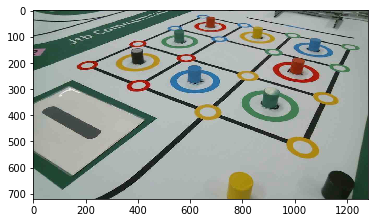

In [6]:
IMAGE_DIR   = "image_fukuyama/"
image = load_image_set(IMAGE_DIR)
plt.imshow(image[0])


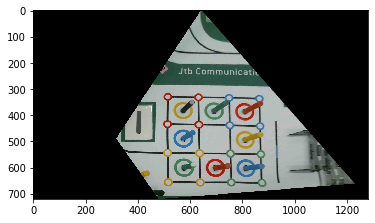

In [15]:
img_psp = persipective_image(image[0])

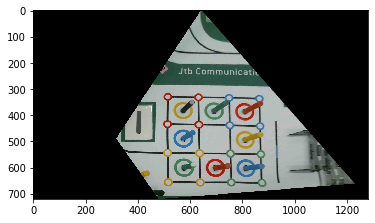

In [12]:
    # 画像読み込み
    img_src = image[0]
    # 画像サイズの取得(横, 縦)
    size = tuple(np.array([img_src.shape[1], img_src.shape[0]]))
 
    # 図のpersipective1の座標を指定
    perspective1 = np.float32([[0, 720],
                              [1280, 720],
                              [1280,0],
                              [0, 0]])
 
    # 図のpersipective2の座標を指定
    perspective2 = np.float32([[317, 489],
                              [480, 720],
                              [1228, 661],
                              [642, 0]])
 
    # 透視変換行列を生成
    psp_matrix = cv2.getPerspectiveTransform(perspective1,perspective2)
 
    # 透視変換を行い、出力
    img_psp = cv2.warpPerspective(img_src, psp_matrix, size)
 
    # 変換後の画像をimageディレクトリ配下に保存
    cv2.imwrite("./image/hanabi_psp.jpg", img_psp)
    plt.imshow(img_psp)
    # 表示
    #cv2.imshow("Show PERSPECTIVE TRANSFORM Image", img_psp)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()